In [1]:
import pandas as pd
from IPython.core.display import HTML
from IPython.core.display import Image 
%load_ext music21.ipython21.ipExtension
import numpy as np
import music21 as mu
import pymongo
%pylab inline
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re
import pydash as py_
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
import math
import music21 as mu
from functools import partial
import itertools
from itertools import chain
# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)


Populating the interactive namespace from numpy and matplotlib


In [2]:
muAutumnLeaves = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAutumnLeaves1996_1371_192.xml')
muStellaByStarlight = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJStellaByStarlight1983_1534_161.xml')
muGroovinHigh = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJGroovinHigh1999_1996_290.xml')
muAllTheThingsYouAre = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml')
muIfIWereABell = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJIfIWereABell2002_2161_227.xml')

In [3]:
df = pd.read_pickle('data_set_as_pk.pkl')

<h4><a id="microphrase">Similar phrases, sequences and patterns</a></h4>

<div>
Similiarity, similiar contour is important...problematic to look for identical things, this prhases seem to be uildt as similtimiliar phrases seem to be in these corposes, so if we don't look for idetnical repetition, but similiartity what is found. This tells us about repetition in a different way, patterns also are revealed - looking at longer phrases
</div>

<div>To explore, this lets look at 3 and 8 note phrases. It becomes computational expensie possible to look at far longer, though they are computation expensive</div>

In [4]:
#utilitity methods to build phrases
def titleAsString(data_row):
    titleAsString = str(data_row[0][0:1][0])
    locationAsString = str(data_row[0][1:2][0])
    return titleAsString + ', measure: ' + locationAsString

def concatenatePhrase(x, data_row):
    phraseArray = []
    startingIndexForNoteDetails = x[1]
    endingIndexForNoteDetails = x[2]
    
    for i in range(0, x[0]):
        phraseArray.append(data_row[i][startingIndexForNoteDetails:endingIndexForNoteDetails])

    return phraseArray

def flagIfNoFrequency(x, data_row):
    flag = 0
    for i in range(0, x):
        if np.isnan(data_row[i][2]):
            flag = 1
    return flag

def createStringForRelevativeFrequencyList(data_row):
    return str(data_row['Phrase with relative frequency only'])

def createFlexiblePhrases(data_row):
    retArr = []
    for item in data_row['Phrase with relative frequency only']:
        arr = []
        formattingArr = []
        
        formattingArr.append(item[0] - 1)
        arr.append(formattingArr)
        formattingArr = []
        formattingArr.append(item[0])
        arr.append(formattingArr)
        formattingArr = []
        formattingArr.append(item[0] + 1)
        arr.append(formattingArr)
        retArr.append(arr)
        

                
    queryArray = []
    for x in itertools.product(*retArr):
        queryArray.append(x)
                
        
    return queryArray

In [5]:
#class to break notes up into individual phrases and track different lengths of phrases
class CreateDataFramesForPhraseAnalysis:
    def __init__(self, dataFrame="", numberOfNotesInPhrase = -1):
        self.df = dataFrame
        self.microPhraseArray = -1
        self.twoNotePhrases = -1
        self.startValueToIncludeFrequencyInPhrase = 2
        self.startValueToExludeFrequency = 3
        self.endValueToExcludeRelativeFrequency = 4
        self.endValueToIncludeAllNoteDetails = 5
        self.numberOfNotesInPhrase = numberOfNotesInPhrase

    def createDataFrames(self):
        dfForPhrasePatterns = self.df[self.df['part'] == 'P1'][['title','measure', 'midiNumber', 'quarterNoteDuration', 'nextNoteFreqDistance', 'noteEventStartingLocation', 'Location in measure']]
        listOfNotes = dfForPhrasePatterns.values.tolist()
        microPhraseLength = self.numberOfNotesInPhrase
        microPhraseArray = []
        microPhrase = []
        for x in range(0, len(listOfNotes)):
            counter = 0
            while(counter < microPhraseLength):
                try:
                    val = listOfNotes[x + counter]
                except:
                    pass
                microPhrase.append(val)
                counter = counter + 1
            microPhraseArray.append(microPhrase)
            microPhrase = []
            
        self.twoNotePhrases = pd.DataFrame(microPhraseArray)

        self.twoNotePhrases['Title and location'] = self.twoNotePhrases.apply(titleAsString, axis=1)
        self.twoNotePhrases['Phrase with relative frequency only'] = self.twoNotePhrases.apply(partial(concatenatePhrase, (self.numberOfNotesInPhrase, self.endValueToExcludeRelativeFrequency, self.endValueToIncludeAllNoteDetails)), axis=1)
        self.twoNotePhrases['No Frequency'] = self.twoNotePhrases.apply(partial(flagIfNoFrequency, self.numberOfNotesInPhrase), axis=1)
        self.twoNotePhrases['Phrase as string'] = self.twoNotePhrases.apply(createStringForRelevativeFrequencyList, axis=1)
        self.twoNotePhrases['Structures of related phrases'] = self.twoNotePhrases.apply(createFlexiblePhrases, axis=1)
        
        
    def removeGhostPhrasesAndUnneededColumns(self):
        self.twoNotePhrases = self.twoNotePhrases[self.twoNotePhrases['No Frequency'] == 0]
        for i in range(0, self.numberOfNotesInPhrase):
            del self.twoNotePhrases[i]
        del self.twoNotePhrases['No Frequency']
        del self.twoNotePhrases['Phrase with relative frequency only']

    def returnDataFramesForAnalysis(self):
        #print self.twoNotePhrases
        return self.twoNotePhrases


<div>Again we will create a list of data frames that hold each of the phrases, and their related phrase</div>

In [6]:
createFiveNotePhraseData = CreateDataFramesForPhraseAnalysis(df, 5)
createFiveNotePhraseData.createDataFrames()
createFiveNotePhraseData.removeGhostPhrasesAndUnneededColumns()
fiveNotephrases = createFiveNotePhraseData.returnDataFramesForAnalysis()



<div>For this, we are looking at rel frequenciy, as that is where most of the commonality is found. The first this is to create a list that has the similiar phrase. So this would look like below</div>

In [7]:
fiveNotephrases.head()

,Title and location,Phrase as string,Structures of related phrases
13,"Stella By Starlight, measure: 3.0","[[2.0], [9.0], [-2.0], [-3.0], [-4.0]]","[([1.0], [8.0], [-3.0], [-4.0], [-5.0]), ([1.0..."
14,"Stella By Starlight, measure: 3.0","[[9.0], [-2.0], [-3.0], [-4.0], [-2.0]]","[([8.0], [-3.0], [-4.0], [-5.0], [-3.0]), ([8...."
15,"Stella By Starlight, measure: 3.0","[[-2.0], [-3.0], [-4.0], [-2.0], [-1.0]]","[([-3.0], [-4.0], [-5.0], [-3.0], [-2.0]), ([-..."
16,"Stella By Starlight, measure: 4.0","[[-3.0], [-4.0], [-2.0], [-1.0], [nan]]","[([-4.0], [-5.0], [-3.0], [-2.0], [nan]), ([-4..."
23,"Stella By Starlight, measure: 5.0","[[1.0], [1.0], [2.0], [1.0], [-1.0]]","[([0.0], [0.0], [1.0], [0.0], [-2.0]), ([0.0],..."


<div>Look at each example of this in notation</div>

In [8]:
listOfQueriesRelatedToPhrases = fiveNotephrases['Structures of related phrases'].values

<div>So what does one of these look like?</div>

In [12]:
def createDataFrameWithRelatedPhrases(phraseFromCorpus, phraseToSend):
    listOfRelatedPhrasesInCorpus = []
    for eachPhraseArchetype in phraseFromCorpus:
        eachPhraseArchetypeAsString =  str(list(eachPhraseArchetype))
        phraseQuery = fiveNotephrases[fiveNotephrases['Phrase as string'] == eachPhraseArchetypeAsString][['Title and location', 'Phrase as string']].values.tolist()
        if len(phraseQuery) != 0:
            listOfRelatedPhrasesInCorpus.append(phraseQuery)

    a = list(chain.from_iterable(listOfRelatedPhrasesInCorpus))
    b = pd.DataFrame(a)
    b['Phrase archetype'] = phraseToSend
    #print b
    return b

In [22]:
arrayOfPhraseQueries = []

for i in range(0, 5):
    phraseToSend = fiveNotephrases.iloc[i]['Phrase as string']
    #print listOfQueriesRelatedToPhrases[i]
    returnedVal = createDataFrameWithRelatedPhrases(listOfQueriesRelatedToPhrases[i], phraseToSend)
    arrayOfPhraseQueries.append(returnedVal)
    

In [28]:
for stuff in arrayOfPhraseQueries:
    print len(stuff)

6
5
35
27
34


In [29]:
arrayOfPhraseQueries[4]

,0,1,Phrase archetype
0,"Stella By Starlight, measure: 156.0","[[0.0], [1.0], [2.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
1,"All The Things You Are, measure: 67.0","[[1.0], [1.0], [1.0], [1.0], [-2.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
2,"All The Things You Are, measure: 164.0","[[1.0], [1.0], [1.0], [1.0], [-2.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
3,"Stella By Starlight, measure: 82.0","[[1.0], [1.0], [1.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
4,"Autumn Leaves, measure: 102.0","[[1.0], [1.0], [1.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
5,"If I Were A Bell, measure: 126.0","[[1.0], [1.0], [1.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
6,"All The Things You Are, measure: 187.0","[[1.0], [1.0], [1.0], [2.0], [-2.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
7,"Autumn Leaves, measure: 26.0","[[1.0], [1.0], [1.0], [2.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
8,"Stella By Starlight, measure: 5.0","[[1.0], [1.0], [2.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"
9,"If I Were A Bell, measure: 221.0","[[1.0], [1.0], [2.0], [1.0], [-1.0]]","[[1.0], [1.0], [2.0], [1.0], [-1.0]]"


In [209]:
len(fiveNotephrases)

6184

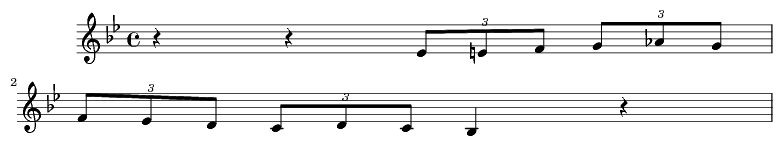

In [31]:
select = muStellaByStarlight.parts[0].measures(5,6)
select.show()

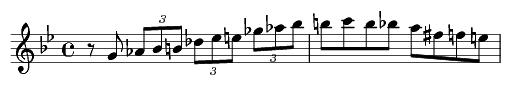

In [32]:
select = muAutumnLeaves.parts[0].measures(41,42)
select.show()